In [ ]:
import os
import sys
import pandas as pd
sys.path.append("../preprocessing/npy")
import sampling as samp
import normalizzation as norm
sys.path.append("../models")
from lstm_model import LSTMModel

fourier/    lstm.ipynb     testAAA/  time/
frequency/  rforest.ipynb  testBBB/  xgboost.ipynb


2025-03-25 11:58:16.046649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-X.Y/lib64
2025-03-25 11:58:16.046670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
partition = input("Inserisci la partizione che vuoi utilizzare")
domain = "fourier" if partition[:2].lower() == "pf" else "time"
print("Hai inserito la partizione: ", partition)
partition = os.path.join("../partitioning/npy", partition)

foldername = input("Inserisci il nome della cartella dove salvare i risultati")
print("Hai inserito la cartella: ", foldername)
foldername = os.path.join(domain, "training_lstm", foldername)
print(foldername)

Hai inserito la partizione:  pt_sq10_over0
Hai inserito la cartella:  testFFFFFFF
time/training_lstm/testFFFFFFF


In [3]:
import tensorflow as tf
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))

GPU disponibile: []


2025-03-25 11:58:29.824994: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-25 11:58:29.825029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (paolo-Katana-15-B13VFK): /proc/driver/nvidia/version does not exist


In [4]:
def load_partitions(root_path):
    file_names = ["X_train.csv", "X_test.csv", "X_val.csv", "y_train.csv", "y_test.csv", "y_val.csv"]
    datasets = [pd.read_csv(os.path.join(root_path, file)).values for file in file_names]
    return tuple(datasets)

# load data
X_train, X_test, X_val, y_train, y_test, y_val = load_partitions(partition)

# show partitions dimention
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (17919, 10), y_train shape: (17919, 1)
X_test shape: (3840, 10), y_test shape: (3840, 1)
X_val shape: (3839, 10), y_val shape: (3839, 1)


In [5]:
window_lag = X_train.shape[1]
input_shape = (window_lag, 1)
input_shape

(10, 1)

In [6]:
window_lag = X_train.shape[1]
input_shape = (window_lag, 1)
print("input_shape: ", input_shape)

input_shape:  (10, 1)


In [7]:
# initialize model
lstm_model = LSTMModel(input_shape, foldername, output_units=y_train.shape[1])

# show model structure
lstm_model.summary()

2025-03-25 11:58:29.898957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [8]:
# training model
lstm_model.train(X_train, y_train, epochs=5, batch_size=32, validation_data = (X_val, y_val))

Epoch 1/5
555/560 [============================>.] - ETA: 0s - loss: 0.0101 - mae: 0.0762 - root_mean_squared_error: 0.0982
Epoch 1: val_loss improved from inf to 0.00722, saving model to time/training_lstm/testFFFFFFF/best_model.keras
560/560 [==============================] - 7s 10ms/step - loss: 0.0100 - mae: 0.0761 - root_mean_squared_error: 0.0980 - val_loss: 0.0072 - val_mae: 0.0646 - val_root_mean_squared_error: 0.0838
Epoch 2/5
552/560 [============================>.] - ETA: 0s - loss: 0.0080 - mae: 0.0679 - root_mean_squared_error: 0.0882
Epoch 2: val_loss improved from 0.00722 to 0.00721, saving model to time/training_lstm/testFFFFFFF/best_model.keras
560/560 [==============================] - 4s 8ms/step - loss: 0.0080 - mae: 0.0679 - root_mean_squared_error: 0.0882 - val_loss: 0.0072 - val_mae: 0.0646 - val_root_mean_squared_error: 0.0837
Epoch 3/5
556/560 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0677 - root_mean_squared_error: 0.0878
Epoch 3: val_

In [19]:
lstm_model.save_training_info_json()

Informazioni di addestramento salvate in time/training_lstm/testFFFFFFF/training_info.json


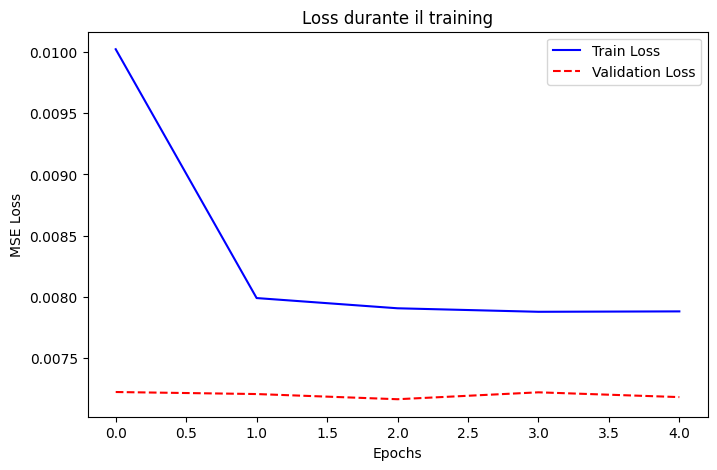

Grafico Loss salvato in time/training_lstm/testFFFFFFF/loss_plot.png


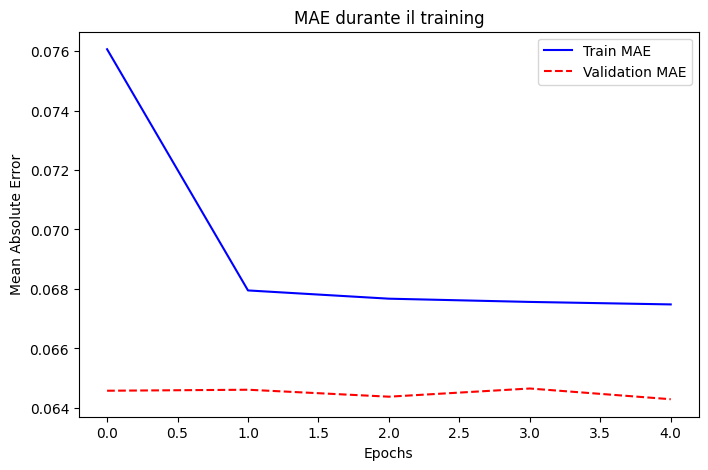

Grafico MAE salvato in time/training_lstm/testFFFFFFF/mae_plot.png


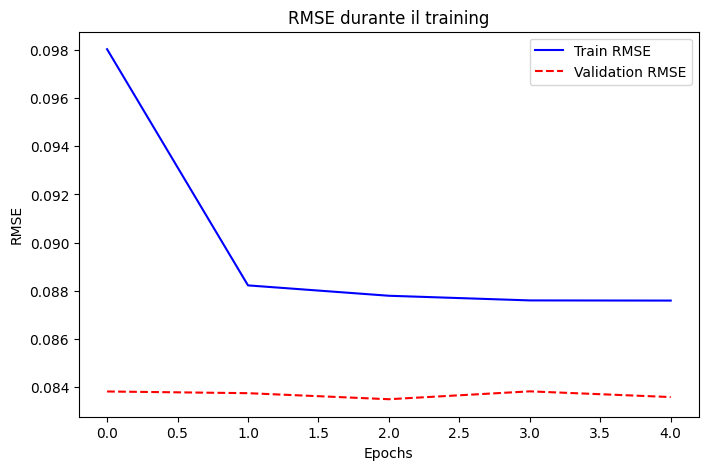

Grafico RMSE salvato in time/training_lstm/testFFFFFFF/rmse_plot.png


In [15]:
lstm_model.plot_training_history()

In [16]:
lstm_model.evaluate(X_test, y_test)

Metriche dettagliate salvate in: time/training_lstm/testFFFFFFF/evaluation_metrics_detailed.csv
Metriche medie salvate in: time/training_lstm/testFFFFFFF/evaluation_metrics_mean.csv


{'detailed': {'Output': ['Unico'],
  'MSE': [0.007353848714573503],
  'RMSE': [0.08575458421899965],
  'MAE': [0.06519294319066275],
  'R2': [0.5797374263424253]},
 'mean': {'Output': ['Unico'],
  'MSE': [0.007353848714573503],
  'RMSE': [0.08575458421899965],
  'MAE': [0.06519294319066275],
  'R2': [0.5797374263424253]}}

In [17]:
y_pred = lstm_model.predict(X_test)  
comparison_df = lstm_model.compare_predictions(y_test, y_pred)  

Confronto predizioni salvato in time/training_lstm/testFFFFFFF/predictions_comparison.csv


In [20]:
lstm_model.save_model()

Modello salvato in time/training_lstm/testFFFFFFF/lstm_model.keras


In [21]:
lstm_model.save_summary()

Sommario del modello salvato in time/training_lstm/testFFFFFFF/model_summary.txt


In [22]:
lstm_model.save_training_history()

Training history salvata in time/training_lstm/testFFFFFFF/training_history.npy
